In [2]:
import numpy as np 
np.random.seed(1234)
import itertools
import functools
from tqdm import tqdm 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline

In [3]:
def get_combinations(x, degree) : 
    return itertools.combinations_with_replacement(x, degree)

def compute_new_feature(items) : 
    return functools.reduce(lambda x, y : x*y, items)

def polynomial_transform(x, degree, logging = False) : 
    # convert to feature matrix 
    if x.ndim == 1 : 
        x = x[:,None]

    x_t = x.transpose()
    feature = [np.ones(len(x))] # populates 1s as first feature for each example 

    if logging : 
        print('Input : ', x)

    for degree in tqdm(range(1, degree + 1)) : 
        for items in get_combinations(x_t, degree) :  # generate combinations
            feature.append(compute_new_feature(items)) # combine feature into a new feature 
            if logging : 
                print(items, " : ", compute_new_feature(items))
    
    if logging : 
        print(np.asarray(feature).transpose())
    
    return np.asarray(feature).transpose()

In [4]:
def linear_combination(X:np.ndarray, w:np.ndarray) -> np.ndarray : 
    return X@ w

def sigmoid(z:np.ndarray) -> np.ndarray : 
    return 1/(1+np.exp(-z))

def predict(X:np.ndarray, w:np.ndarray, threshold:float) -> np.ndarray : 
    return np.where(sigmoid(linear_combination(X, w)) > threshold, 1, 0)

In [5]:
feature_matrix = np.array([[1, 20, 2], [1, 2, 2]]) 
weight_vector = np.array([-1, 0, 1])

class_labels = predict(feature_matrix, weight_vector, 0.5)
print(class_labels.shape)
print(class_labels)

(2,)
[1 1]


if sum of l1 and l2 reg_rate is 1 then its called elastic net 

In [6]:
def loss(y, sigmoid_vector, weight_vector, li_reg_rate, l2_reg_rate) : 
    return (-1 * (np.sum(y * np.log(sigmoid_vector) + (1-y) * np.log(1-sigmoid_vector)))
    + l2_reg_rate * np.dot(np.transpose(weight_vector), weight_vector)
    + l1_reg_rate * np.sum(np.abs(weight_vector)))

def calculate_gradient(X:np.ndarray, y:np.ndarray, w:np.ndarray, reg_rate:float) -> np.ndarray : 
    return np.transpose(X) @ (sigmoid(linear_combination(X, w)) - y) + reg_rate * w  

In [8]:
class LogisticRegression(object):

    '''Logistic Regression model

        y = sigmoid(X @ w)
    '''
    
    def set_weight_vector(self, w):
        self.w = w
    
    def linear_combination(self, X:np.ndarray) -> np.ndarray:
        '''Calculates linear combination of features.
    
        The linear combination is calculated witht he following vectorised form

        z = Xw
        Args:
            X: feature matrix with shape(n, m)
            w: weight vector with shape(m,)

        Returns:
            Linear combination of features with shape (n,)
        
        '''
        return X @ self.w

    def sigmoid(self, z: np.ndarray) -> np.ndarray:
        '''Calculates sigmoid of linear combination of features z
    
         Args:
            z: list of floats

            Returns:
                 Sigmoid function of linear combination of features as an array
        '''

        return 1/(1 + np.exp(-z))
    
    def activation(self, X:np.ndarray) -> np.ndarray:
        '''Calculates sigmoid activation for logistic regression.
        
        Args:
            X: Feature matrix with shape (n, m)

        Returns:
            activation vector with shape (n,)
        '''
        
        return self.sigmoid(self.linear_combination(X))

    def predict(self, X: np.ndarray, threshold=0.5) -> np.ndarray:
        '''Predicts class label for samples

        Args:
            X: feature matrix with shape(n, m)
            w: weight vector with shape(m,)
            threshold: Probability the=reshold for prediction
    
        Returns:
            Predicted class labels
        '''
        return np.where(self.activation(X) > threshold, 1, 0).astype(int)

    def loss(self, X:np.ndarray, y:np.ndarray, reg_rate:float) -> float:
        '''Calculate loss function for a given weight vactor

        Args:
            X: feature matrix with shape(n, m)
            y: label vector with shape(n,)
            w: weight vector with shape(m,)
            reg_rate: L2 regularisation rate

        Returns:
            Loss function
        '''
        predicted_prob = self.activation(X)
        return (-1 * (np.sum(y @ np.log(predicted_prob)) + (1 - y) @ np.log(1 - predicted_prob)))  + reg_rate * np.dot(self.w.T, self.w)

    def calculate_gradient(self, X:np.ndarray, y:np.ndarray, reg_rate: float) -> np.ndarray:
        '''Calculates gradients of loss function wrt weight vector on training set

        Args: 
            X: Feature matrix for training data.
            y:Label vector for training data.
            reg_rate: regularisation rate

        Returns:
            A vector of gradients
        '''

        return X.T @ (self.activation(X) - y) + reg_rate * self.w

    def update_weights(self, grad:np.ndarray, lr:float) -> np.ndarray:
        '''Updates the weights based on the gradient of loss function
        Args:
            1. w: Weight vector
            2. grad: gradient of loss w.r.t w
            3.  lr: learning rate
        Returns:
            Updated weights
        '''
        return (self.w - lr*grad)

    def gd(self, X:np.ndarray, y:np.ndarray, num_epochs:int, lr:float, reg_rate:float) -> np.ndarray:
        '''Estimates the parameters of logistic regression model with gradient descent'
    
        Args:
            X: Feaature matrix for training data.
            y: Label vector for traaining data.
            num_epochs: NUmber of training steps
            lr: Learning rate
            reg_rate: Regularisation rate

        Returns:
            Weight vector: Final weight vector
        '''

        self.w = np.zeros(X.shape[1])
        self.w_all = []
        self.err_all = []

        for i in tqdm(np.arange(0, num_epochs)):
            
            dJdW = self.calculate_gradient(X, y, reg_rate)
            self.w_all.append(self.w)
            self.err_all.append(self.loss(X, y, reg_rate))
            self.w = self.update_weights(dJdW, lr)

        return self.w 


In [9]:
def create_toy_data() : 
    x0 = np.random.normal(size = 50).reshape(-1, 2) - 1
    x1 = np.random.normal(size = 50).reshape(-1, 2) + 1
    return np.concatenate([x0, x1]), np.concatenate([np.zeros(25), np.ones(25)]).astype(int)

In [10]:
feature_matrix, label_vector = create_toy_data()
print(feature_matrix.shape) 
print(label_vector.shape) 

(50, 2)
(50,)


In [11]:
assert feature_matrix.shape[0] == label_vector.shape[0]

copy all the features along with 0 degree feature

In [12]:
feature_matrix_bias = polynomial_transform(feature_matrix, degree= 1)

100%|██████████| 1/1 [00:00<?, ?it/s]


In [13]:
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(feature_matrix_bias, label_vector)

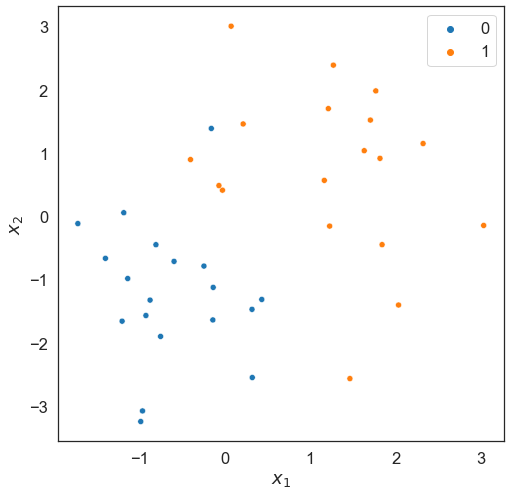

In [14]:
sns.set_style('white')
f = plt.figure(figsize= (8,8))
sns.set_context('notebook', font_scale=1.5, rc = {'lines.linewidth' : 2.5})

sns.scatterplot(data = x_train, x = x_train[:, -2], y = x_train[:,-1], hue = y_train)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

In [15]:
log_reg = LogisticRegression()
log_reg.gd(x_train, y_train, num_epochs = 1000, reg_rate = 0, lr = 1e-2)

100%|██████████| 1000/1000 [00:00<00:00, 15150.81it/s]


array([-0.14559758,  4.43289743,  1.94514132])

In [16]:
def plot_learning_curve(err):
    plt.plot(np.arange(len(err)), err, 'r-')
    plt.xlabel('Iter #')
    plt.ylabel('$\mathbf{J(w)}$')

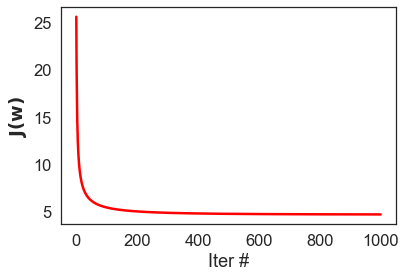

In [17]:
plot_learning_curve(log_reg.err_all)

In [18]:
sns.set_context('notebook', font_scale= 1.5, rc = {'lines.linewidth' : 2.5})

def visualize_model(x_train, labels, lsc_obj, degree = 1) : 
    f = plt.figure(figsize=(8, 8))

    x1_min = np.min(x_train[:,1])
    x1_max = np.max(x_train[:,1])
    x2_min = np.min(x_train[:,2])
    x2_max = np.max(x_train[:,2])

    x1_test, x2_test = np.meshgrid(np.linspace(x1_min, x1_max, 100), np.linspace(x2_min, x2_max, 100))
    x_test = np.array([x1_test, x2_test]).reshape(2, -1).T
    x_test_poly = polynomial_transform(x_test, degree= degree)
    y_test = lsc_obj.predict(x_test_poly)

    sns.scatterplot(data = x_train, x = x_train[:, 1], y = x_train[:,2], hue = labels)
    plt.contourf(x1_test, x2_test, y_test.reshape(100, 100), alpha = 0.5, levels = np.linspace(0, 1, 3))

    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.xlim(x1_min, x1_max)
    plt.ylim(x2_min, x2_max)
    plt.gca().set_aspect('equal', adjustable = 'box')
    plt.show()

100%|██████████| 1/1 [00:00<?, ?it/s]


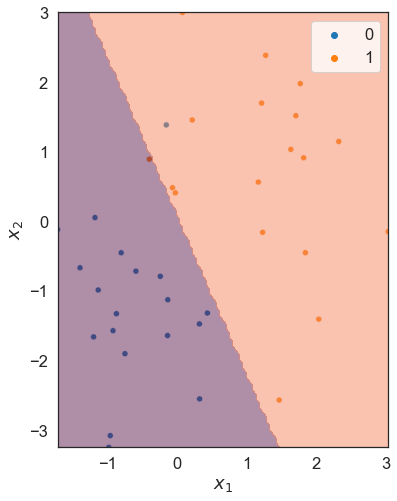

In [19]:
visualize_model(x_train, y_train, log_reg)

In [20]:
y_test_hat = log_reg.predict(x_test)

from sklearn.metrics import classification_report 

print(classification_report(y_test, y_test_hat, zero_division = 0))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       0.78      1.00      0.88         7

    accuracy                           0.85        13
   macro avg       0.89      0.83      0.84        13
weighted avg       0.88      0.85      0.84        13



In [21]:
from sklearn.datasets import make_circles
x, y = make_circles()

In [22]:
x_poly = polynomial_transform(x, degree= 2)
x_train, x_test, y_train, y_test = train_test_split(x_poly, y)

100%|██████████| 2/2 [00:00<?, ?it/s]


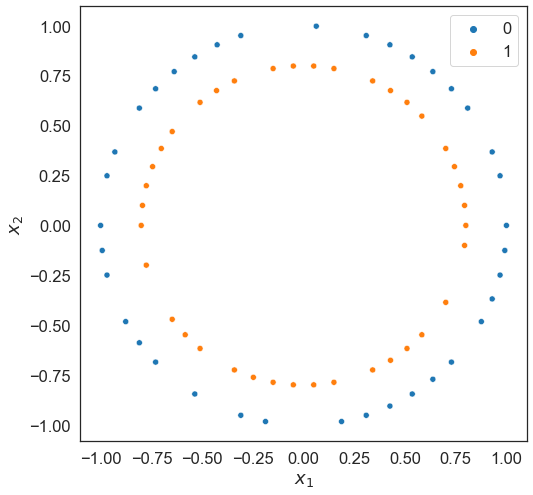

In [23]:
sns.set_style('white')
f = plt.figure(figsize= (8,8))
sns.set_context('notebook', font_scale=1.5, rc = {'lines.linewidth' : 2.5})

sns.scatterplot(data = x_train, x = x_train[:, 1], y = x_train[:,2], hue = y_train)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

In [24]:
log_reg_poly = LogisticRegression()
log_reg_poly.gd(x_train, y_train, num_epochs=10000, lr =1e-2, reg_rate=0)

100%|██████████| 10000/10000 [00:00<00:00, 15532.81it/s]


array([ 2.03212877e+01, -3.62360899e-02,  7.36788518e-03, -2.49434641e+01,
        1.06058158e-01, -2.47207876e+01])

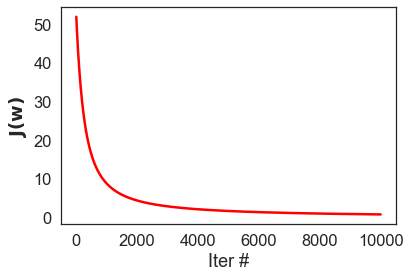

In [25]:
plot_learning_curve(log_reg_poly.err_all)

100%|██████████| 2/2 [00:00<00:00, 2004.93it/s]


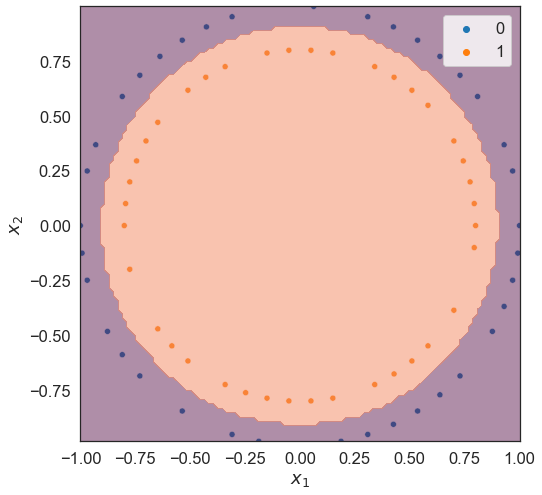

In [26]:
visualize_model(x_train, y_train, log_reg_poly, degree=2)

In [27]:
y_test_hat = log_reg_poly.predict(x_test)

from sklearn.metrics import classification_report 

print(classification_report(y_test, y_test_hat, zero_division = 0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        12

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



In [28]:
from matplotlib import cm 
from matplotlib.colors import colorConverter, ListedColormap

In [29]:
log_reg_vis = LogisticRegression()

In [30]:
feature_matrix, label_vector = create_toy_data()
feature_matrix_bias = polynomial_transform(feature_matrix, degree=1)
x_train, x_test, y_train, y_test = train_test_split(feature_matrix_bias, label_vector)

100%|██████████| 1/1 [00:00<00:00, 426.86it/s]


In [31]:
point_count = 25 
w1 = np.linspace(-5, 5, num = point_count)
w2 = np.linspace(-5, 5, num = point_count)
w1_list, w2_list = np.meshgrid(w1, w2)

In [32]:
loss = np.zeros((point_count, point_count))

for i in range(point_count) : 
    for j in range(point_count) : 
        weight_vector = np.array([0, w1_list[i, j], w2_list[i, j]])
        log_reg_vis.set_weight_vector(weight_vector)
        loss[i, j] = log_reg_vis.loss(x_train, y_train, reg_rate=0)

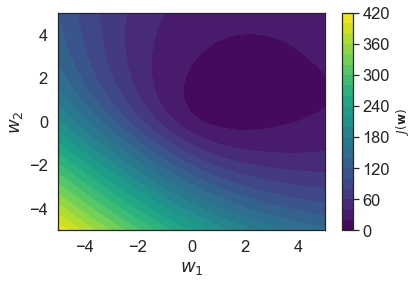

In [33]:
plt.figure(figsize=(6, 4))
plt.contourf(w1_list, w2_list, loss, 20, cmap = cm.viridis)
cbar = plt.colorbar()
cbar.ax.set_ylabel('$J(\mathbf{w})$', fontsize =12)
plt.xlabel('$w_1$')
plt.ylabel('$w_2$')
plt.grid()
plt.show()

In [36]:
log_reg_vis.gd(x_train, y_train, num_epochs = 10000, reg_rate = 0, lr = 1e-2)

100%|██████████| 10000/10000 [00:00<00:00, 19781.39it/s]


array([0.69580675, 1.6136248 , 0.87521978])

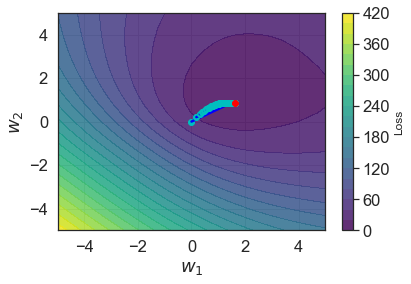

: 

In [37]:
plt.figure(figsize=(6, 4))
plt.contourf(w1_list, w2_list, loss, 20, alpha = 0.85, cmap = cm.viridis)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Loss', fontsize =12)

for i in range(1, 900) : 
    w1 = log_reg_vis.w_all[(i-1)]
    w2 = log_reg_vis.w_all[(i+100)]
    plt.plot(w1[1], w1[2], marker = 'o', color = 'c')
    plt.plot([w1[1], w2[1]], [w1[2], w2[2]], linestyle = '-', color = 'b')

w1 = log_reg_vis.w_all[-1]
plt.plot(w1[1], w2[2], marker = 'o', color = 'r')
plt.xlabel('$w_1$')
plt.ylabel('$w_2$')
plt.grid()
plt.show()